In [1]:
%matplotlib inline

## Software Comparison Project with NIDM-Results

This notebook demonstates how to reproduce the results presented in the Software Comparison Project publication using NIDM-Results packs available at [NeuroVault (2209)](https://neurovault.org/collections/2209/). We give visual comparisons between axial slices of the excursion set images and T-statistics for each software packages, as well as quantitative comparisons with Euler Characteristics, Bland-Altman plots and Sørensen–Dice coefficients.


In [2]:
import os
from subprocess import check_call
import zipfile
import json
from urllib2 import urlopen, URLError, HTTPError
from urllib2 import Request
from nilearn import plotting
import nipype

### Download the NIDM-Results packs from NeuroVault

 - Query NeuroVault's API to retreive all NIDM packs in collection 2071
 - Download and save the packs in sub-folder `input/ds001` 

In [3]:
nv_collection ='2209'
study ='ds001'


request = Request('http://neurovault.org/api/collections/' + nv_collection + '/nidm_results/?limit=184&format=json')
response = urlopen(request)
elevations = response.read()
data = json.loads(elevations)

pwd = os.path.dirname(os.path.realpath('__file__'))
input_dir = os.path.join(pwd, "input")
data_dir = os.path.join(input_dir, study)

if not os.path.isdir(data_dir):
    if not os.path.isdir(input_dir):
        os.makedirs(input_dir)
    os.makedirs(data_dir)

for nidm_result in data["results"]:
    url = nidm_result["zip_file"]
    study_name = nidm_result["name"]

    localzip = os.path.join(data_dir, study_name + ".zip")
    localzip_rel = localzip.replace(pwd, '.')
    if not os.path.isfile(localzip):
        # Copy .nidm.zip export locally in a the data directory
        try:
            f = urlopen(url)
            print("downloading " + url + " at " + localzip_rel)
            with open(localzip, "wb") as local_file:
                local_file.write(f.read())
        except HTTPError, e:
            raise Exception(["HTTP Error:" + str(e.code) + url])
        except URLError, e:
            raise Exception(["URL Error:" + str(e.reason) + url])
    else:
        print(url + " already downloaded at " + localzip_rel)

for afni_image, local_name in (
        ('Negative_clustered_t_stat.nii.gz', 'afni_exc_set_neg.nii.gz'), 
        ('Positive_clustered_t_stat.nii.gz', 'afni_exc_set_pos.nii.gz'),
        ('3dMEMA_result_t_stat_masked.nii.gz', 'afni_stat.nii.gz'),
        ('mask.nii.gz', 'afni_mask.nii.gz')):

    url = "http://neurovault.org/media/images/" + nv_collection + '/' + afni_image
    local_file = os.path.join(data_dir, local_name)
    if not os.path.isfile(local_file):
        # Copy file locally in a the data directory
        try:
            f = urlopen(url)
            print("downloading " + url + " at " + local_file)
            with open(local_file, "wb") as local_fid:
                local_fid.write(f.read())
        except HTTPError, e:
            raise Exception(["HTTP Error:" + str(e.code) + url])
        except URLError, e:
            raise Exception(["URL Error:" + str(e.reason) + url])
    else:
        print(url + " already downloaded at " + local_file)

for euler_char_file, local_name in (
        ('AFNI/LEVEL2/euler_chars.csv', 'afni_euler_chars.csv'),
        ('FSL/LEVEL2/group.gfeat/cope1.feat/stats/euler_chars.csv', 'fsl_euler_chars.csv'),
        ('SPM/LEVEL2/euler_chars.csv', 'spm_euler_chars.csv'),
        ('AFNI/LEVEL2/permutation_test/euler_chars.csv', 'afni_perm_euler_chars.csv'),
        ('FSL/LEVEL2/permutation_test/euler_chars.csv', 'fsl_perm_euler_chars.csv'),
        ('SPM/LEVEL2/permutation_test/euler_chars.csv', 'spm_perm_euler_chars.csv')):

    url = "https://raw.githubusercontent.com/AlexBowring/Software_Comparison/mean_mni_images/" + study + "/" + euler_char_file
    local_file = os.path.join(data_dir, local_name)
    if not os.path.isfile(local_file):
        # Copy file locally in a the data directory
        try:
            f = urlopen(url)
            print("downloading " + url + " at " + local_file)
            with open(local_file, "wb") as local_fid:
                local_fid.write(f.read())
        except HTTPError, e:
            raise Exception(["HTTP Error:" + str(e.code) + url])
        except URLError, e:
            raise Exception(["URL Error:" + str(e.reason) + url])
    else:
        print(url + " already downloaded at " + local_file)
        
for resliced_image in (('afni_fsl_reslice.nii.gz', 'afni_fsl_reslice_pos_exc.nii.gz','afni_fsl_reslice_neg_exc.nii.gz',
                        'afni_reslice_fsl.nii.gz', 'afni_reslice_fsl_pos_exc.nii.gz','afni_reslice_fsl_neg_exc.nii.gz',
                        'afni_spm_reslice.nii.gz', 'afni_spm_reslice_pos_exc.nii.gz','afni_spm_reslice_neg_exc.nii.gz',
                        'afni_reslice_spm.nii.gz', 'afni_reslice_spm_pos_exc.nii.gz','afni_reslice_spm_neg_exc.nii.gz',
                        'fsl_spm_reslice.nii.gz', 'fsl_spm_reslice_pos_exc.nii.gz','fsl_spm_reslice_neg_exc.nii.gz',
                        'fsl_reslice_spm.nii.gz', 'fsl_reslice_spm_pos_exc.nii.gz','fsl_reslice_spm_neg_exc.nii.gz',
                        'afni_fsl_reslice_perm.nii.gz', 'afni_fsl_reslice_pos_exc_perm.nii.gz', 'afni_fsl_reslice_neg_exc_perm.nii.gz',
                        'afni_reslice_fsl_perm.nii.gz', 'afni_reslice_fsl_pos_exc_perm.nii.gz', 'afni_reslice_fsl_neg_exc_perm.nii.gz',
                        'afni_spm_reslice_perm.nii.gz', 'afni_spm_reslice_pos_exc_perm.nii.gz', 'afni_spm_reslice_neg_exc_perm.nii.gz',
                        'afni_reslice_spm_perm.nii.gz', 'afni_reslice_spm_pos_exc_perm.nii.gz', 'afni_reslice_spm_neg_exc_perm.nii.gz',
                        'fsl_spm_reslice_perm.nii.gz', 'fsl_spm_reslice_pos_exc_perm.nii.gz', 'fsl_spm_reslice_neg_exc_perm.nii.gz',
                        'fsl_reslice_spm_perm.nii.gz', 'fsl_reslice_spm_pos_exc_perm.nii.gz', 'fsl_reslice_spm_neg_exc_perm.nii.gz',
                        'afni_perm_reslice_fsl_pos_exc.nii.gz', 'afni_perm_reslice_fsl_neg_exc.nii.gz',
                        'afni_perm_fsl_reslice_pos_exc.nii.gz', 'afni_perm_fsl_reslice_neg_exc.nii.gz',                        
                        'afni_reslice_fsl_perm_pos_exc.nii.gz', 'afni_reslice_fsl_perm_neg_exc.nii.gz',
                        'afni_fsl_perm_reslice_pos_exc.nii.gz', 'afni_fsl_perm_reslice_neg_exc.nii.gz',                        
                        'afni_perm_reslice_spm_pos_exc.nii.gz', 'afni_perm_reslice_spm_neg_exc.nii.gz',
                        'afni_perm_spm_reslice_pos_exc.nii.gz', 'afni_perm_spm_reslice_neg_exc.nii.gz',                        
                        'afni_reslice_spm_perm_pos_exc.nii.gz', 'afni_reslice_spm_perm_neg_exc.nii.gz',
                        'afni_spm_perm_reslice_pos_exc.nii.gz', 'afni_spm_perm_reslice_neg_exc.nii.gz',                        
                        'fsl_perm_reslice_spm_pos_exc.nii.gz', 'fsl_perm_reslice_spm_neg_exc.nii.gz',
                        'fsl_perm_spm_reslice_pos_exc.nii.gz', 'fsl_perm_spm_reslice_neg_exc.nii.gz',        
                        'fsl_reslice_spm_perm_pos_exc.nii.gz', 'fsl_reslice_spm_perm_neg_exc.nii.gz',
                        'fsl_spm_perm_reslice_pos_exc.nii.gz', 'fsl_spm_perm_reslice_neg_exc.nii.gz')):
    
    url = "http://neurovault.org/media/images/" + nv_collection + '/' + resliced_image
    local_file = os.path.join(data_dir, resliced_image)
    if not os.path.isfile(local_file):
        # Copy file locally in a the data directory
        try:
            f = urlopen(url)
            print("downloading " + url + " at " + local_file)
            with open(local_file, "wb") as local_fid:
                local_fid.write(f.read())
        except HTTPError, e:
            raise Exception(["HTTP Error:" + str(e.code) + url])
        except URLError, e:
            raise Exception(["URL Error:" + str(e.reason) + url])
    else:
        print(url + " already downloaded at " + local_file)
        
for perm_image, local_name in (
        ('perm_ttest++_Clustsim_result_t_stat_masked.nii.gz', 'afni_perm.nii.gz'), 
        ('perm_Positive_clustered_t_stat.nii.gz', 'afni_perm_exc_set_pos.nii.gz'),
        ('perm_Negative_clustered_t_stat.nii.gz', 'afni_perm_exc_set_neg.nii.gz'),
        ('perm_mask.nii.gz', 'afni_perm_mask.nii.gz'),
        ('OneSampT_tstat1.nii.gz', 'fsl_perm.nii.gz'),
        ('05FWECorrected_OneSampT_pos_exc_set.nii.gz', 'fsl_perm_exc_set_pos.nii.gz'),
        ('05FWECorrected_OneSampT_neg_exc_set.nii.gz', 'fsl_perm_exc_set_neg.nii.gz'),
        ('snpmT%2B.nii.gz', 'spm_perm.nii.gz'),
        ('SnPM_pos_filtered.nii.gz', 'spm_perm_exc_set_pos.nii.gz'),
        ('SnPM_neg_filtered.nii.gz', 'spm_perm_exc_set_neg.nii.gz')):

    url = "http://neurovault.org/media/images/" + nv_collection + '/' + perm_image
    local_file = os.path.join(data_dir, local_name)
    if not os.path.isfile(local_file):
        # Copy file locally in a the data directory
        try:
            f = urlopen(url)
            print("downloading " + url + " at " + local_file)
            with open(local_file, "wb") as local_fid:
                local_fid.write(f.read())
        except HTTPError, e:
            raise Exception(["HTTP Error:" + str(e.code) + url])
        except URLError, e:
            raise Exception(["URL Error:" + str(e.reason) + url])
    else:
        print(url + " already downloaded at " + local_file)

https://neurovault.org/collections/2209/group.gfeat.nidm.zip already downloaded at ./input/ds001/group.gfeat.nidm.zip
https://neurovault.org/collections/2209/spm_0001.nidm.zip already downloaded at ./input/ds001/spm_0001.nidm.zip
https://neurovault.org/collections/2209/spm_0002.nidm.zip already downloaded at ./input/ds001/spm_0002.nidm.zip
http://neurovault.org/media/images/2209/Negative_clustered_t_stat.nii.gz already downloaded at /Users/maullz/Desktop/Software_Comparison/figures/input/ds001/afni_exc_set_neg.nii.gz
http://neurovault.org/media/images/2209/Positive_clustered_t_stat.nii.gz already downloaded at /Users/maullz/Desktop/Software_Comparison/figures/input/ds001/afni_exc_set_pos.nii.gz
http://neurovault.org/media/images/2209/3dMEMA_result_t_stat_masked.nii.gz already downloaded at /Users/maullz/Desktop/Software_Comparison/figures/input/ds001/afni_stat.nii.gz
http://neurovault.org/media/images/2209/mask.nii.gz already downloaded at /Users/maullz/Desktop/Software_Comparison/figu

In [4]:
import zipfile
import shutil
import pandas as pd

# *** SPM group activations
spm_pack = open('./input/' + study + '/spm_0001.nidm.zip', 'rb')
z = zipfile.ZipFile(spm_pack)
z.extract('ExcursionSet.nii.gz', './input/' + study + '/')
z.extract('Mask.nii.gz', './input/' + study + '/')
z.extract('TStatistic.nii.gz', './input/' + study + '/')

# Thresholded statistics
spm_exc_set_file = './input/' + study + '/spm_exc_set.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet.nii.gz', spm_exc_set_file)

# Unthresholded statistics
spm_stat_file = './input/' + study + '/spm_stat.nii.gz'
shutil.move('./input/' + study + '/TStatistic.nii.gz', spm_stat_file)

# Analysis mask
spm_mask_file = './input/' + study + '/spm_mask.nii.gz'
shutil.move('./input/' + study + '/Mask.nii.gz', spm_mask_file)

# *** SPM group deactivations
spm_deact_pack = open('./input/' + study + '/spm_0002.nidm.zip', 'rb')
z = zipfile.ZipFile(spm_deact_pack)
z.extract('ExcursionSet.nii.gz', './input/' + study + '/')

# Thresholded statistics
spm_exc_set_file_neg = './input/' + study + '/spm_exc_set_neg.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet.nii.gz', spm_exc_set_file_neg)

# *** FSL group activations and deactivations
fsl_pack = open('./input/' + study + '/group.gfeat.nidm.zip', 'rb')
z = zipfile.ZipFile(fsl_pack)
z.extract('ExcursionSet_T001.nii.gz', './input/' + study + '/')
z.extract('ExcursionSet_T002.nii.gz', './input/' + study + '/')
z.extract('Mask.nii.gz', './input/' + study + '/')
z.extract('TStatistic_T001.nii.gz', './input/' + study + '/')

# Thresholded statistics
fsl_exc_set_file = './input/' + study + '/fsl_exc_set.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T001.nii.gz', fsl_exc_set_file)
fsl_exc_set_file_neg = './input/' + study + '/fsl_exc_set_neg.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T002.nii.gz', fsl_exc_set_file_neg)

# Unthresholded statistics
fsl_stat_file = './input/' + study + '/fsl_stat.nii.gz'
shutil.move('./input/' + study + '/TStatistic_T001.nii.gz', fsl_stat_file)

# Analysis mask
fsl_mask_file = './input/' + study + '/fsl_mask.nii.gz'
shutil.move('./input/' + study + '/Mask.nii.gz', fsl_mask_file)

# *** AFNI group activations and deactivations
afni_mask_file = './input/' + study + '/afni_mask.nii.gz'
afni_exc_set_file = './input/' + study + '/afni_exc_set_pos.nii.gz'
afni_exc_set_file_neg = './input/' + study + '/afni_exc_set_neg.nii.gz'
afni_stat_file = './input/' + study + '/afni_stat.nii.gz'

exc_sets = dict()
exc_sets["spm"] = (spm_mask_file, (spm_exc_set_file, spm_exc_set_file_neg), spm_stat_file)
exc_sets["fsl"] = (fsl_mask_file, (fsl_exc_set_file, fsl_exc_set_file_neg), fsl_stat_file)
exc_sets["afni"] = (afni_mask_file, (afni_exc_set_file, afni_exc_set_file_neg), afni_stat_file)

# *** Resliced images
# FSL resliced onto AFNI
afni_fsl_reslice = './input/' + study + '/afni_fsl_reslice.nii.gz'
afni_fsl_reslice_pos_exc = './input/' + study + '/afni_fsl_reslice_pos_exc.nii.gz'
afni_fsl_reslice_neg_exc = './input/' + study + '/afni_fsl_reslice_neg_exc.nii.gz'
# AFNI resliced onto FSL
afni_reslice_fsl = './input/' + study + '/afni_reslice_fsl.nii.gz'
afni_reslice_fsl_pos_exc = './input/' + study + '/afni_reslice_fsl_pos_exc.nii.gz'
afni_reslice_fsl_neg_exc = './input/' + study + '/afni_reslice_fsl_neg_exc.nii.gz'

# SPM resliced onto AFNI
afni_spm_reslice = './input/' + study + '/afni_spm_reslice.nii.gz'
afni_spm_reslice_pos_exc = './input/' + study + '/afni_spm_reslice_pos_exc.nii.gz'
afni_spm_reslice_neg_exc = './input/' + study + '/afni_spm_reslice_neg_exc.nii.gz'
# AFNI resliced onto SPM
afni_reslice_spm = './input/' + study + '/afni_reslice_spm.nii.gz'
afni_reslice_spm_pos_exc = './input/' + study + '/afni_reslice_spm_pos_exc.nii.gz'
afni_reslice_spm_neg_exc = './input/' + study + '/afni_reslice_spm_neg_exc.nii.gz'

# SPM resliced onto FSL
fsl_spm_reslice  = './input/' + study + '/fsl_spm_reslice.nii.gz'
fsl_spm_reslice_pos_exc = './input/' + study + '/fsl_spm_reslice_pos_exc.nii.gz'
fsl_spm_reslice_neg_exc = './input/' + study + '/fsl_spm_reslice_neg_exc.nii.gz'
# FSL resliced onto SPM
fsl_reslice_spm = './input/' + study + '/fsl_reslice_spm.nii.gz'
fsl_reslice_spm_pos_exc = './input/' + study + '/fsl_reslice_spm_pos_exc.nii.gz'
fsl_reslice_spm_neg_exc = './input/' + study + '/fsl_reslice_spm_neg_exc.nii.gz'

# *** Euler Characteristics
afni_euler_chars = pd.read_csv('./input/' + study + '/afni_euler_chars.csv', header=None, names=['Threshold','AFNI EC'])
fsl_euler_chars = pd.read_csv('./input/' + study + '/fsl_euler_chars.csv', usecols=[1], header=None, names=['FSL EC'])
spm_euler_chars = pd.read_csv('./input/' + study + '/spm_euler_chars.csv', usecols=[1], header=None, names=['SPM EC'])
euler_chars = pd.concat([afni_euler_chars, fsl_euler_chars, spm_euler_chars], axis=1)

# *** Permutation Test images
afni_perm = './input/' + study + '/afni_perm.nii.gz'
afni_perm_pos_exc = './input/' + study + '/afni_perm_exc_set_pos.nii.gz'
afni_perm_neg_exc = './input/' + study + '/afni_perm_exc_set_neg.nii.gz'
afni_perm_mask = './input/' + study + '/afni_mask_perm.nii.gz'
fsl_perm = './input/' + study + '/fsl_perm.nii.gz'
fsl_perm_pos_exc = './input/' + study + '/fsl_perm_exc_set_pos.nii.gz'
fsl_perm_neg_exc = './input/' + study + '/fsl_perm_exc_set_neg.nii.gz'
spm_perm = './input/' + study + '/spm_perm.nii.gz'
spm_perm_pos_exc = './input/' + study + '/spm_perm_exc_set_pos.nii.gz'
spm_perm_neg_exc = './input/' + study + '/spm_perm_exc_set_neg.nii.gz'

perm_exc_sets = dict()
perm_exc_sets["spm permutation"] = (spm_mask_file, (spm_perm_pos_exc, spm_perm_neg_exc), spm_perm)
perm_exc_sets["fsl permutation"] = (fsl_mask_file, (fsl_perm_pos_exc, fsl_perm_neg_exc), fsl_perm)
perm_exc_sets["afni permutation"] = (afni_perm_mask, (afni_perm_pos_exc, afni_perm_neg_exc), afni_perm)

# *** Permutation Test Resliced images
# FSL resliced onto AFNI
afni_fsl_reslice_perm = './input/' + study + '/afni_fsl_reslice_perm.nii.gz'
afni_fsl_reslice_pos_exc_perm = './input/' + study + '/afni_fsl_reslice_pos_exc_perm.nii.gz'
afni_fsl_reslice_neg_exc_perm = './input/' + study + '/afni_fsl_reslice_neg_exc_perm.nii.gz'
# AFNI resliced onto FSL
afni_reslice_fsl_perm = './input/' + study + '/afni_reslice_fsl_perm.nii.gz'
afni_reslice_fsl_pos_exc_perm = './input/' + study + '/afni_reslice_fsl_pos_exc_perm.nii.gz'
afni_reslice_fsl_neg_exc_perm = './input/' + study + '/afni_reslice_fsl_neg_exc_perm.nii.gz'

# SPM resliced onto AFNI
afni_spm_reslice_perm = './input/' + study + '/afni_spm_reslice_perm.nii.gz'
afni_spm_reslice_pos_exc_perm = './input/' + study + '/afni_spm_reslice_pos_exc_perm.nii.gz'
afni_spm_reslice_neg_exc_perm = './input/' + study + '/afni_spm_reslice_neg_exc_perm.nii.gz'
# AFNI resliced onto SPM
afni_reslice_spm_perm = './input/' + study + '/afni_reslice_spm_perm.nii.gz'
afni_reslice_spm_pos_exc_perm = './input/' + study + '/afni_reslice_spm_pos_exc_perm.nii.gz'
afni_reslice_spm_neg_exc_perm = './input/' + study + '/afni_reslice_spm_neg_exc_perm.nii.gz'

# SPM resliced onto FSL
fsl_spm_reslice_perm  = './input/' + study + '/fsl_spm_reslice_perm.nii.gz'
fsl_spm_reslice_pos_exc_perm = './input/' + study + '/fsl_spm_reslice_pos_exc_perm.nii.gz'
fsl_spm_reslice_neg_exc_perm = './input/' + study + '/fsl_spm_reslice_neg_exc_perm.nii.gz'
# FSL resliced onto SPM
fsl_reslice_spm_perm = './input/' + study + '/fsl_reslice_spm_perm.nii.gz'
fsl_reslice_spm_pos_exc_perm = './input/' + study + '/fsl_reslice_spm_pos_exc_perm.nii.gz'
fsl_reslice_spm_neg_exc_perm = './input/' + study + '/fsl_reslice_spm_neg_exc_perm.nii.gz'

# *** Permutation Test Euler Characteristics
afni_perm_euler_chars = pd.read_csv('./input/' + study + '/afni_perm_euler_chars.csv', header=None, names=['Threshold','AFNI EC'])
fsl_perm_euler_chars = pd.read_csv('./input/' + study + '/fsl_perm_euler_chars.csv', usecols=[1], header=None, names=['FSL EC'])
spm_perm_euler_chars = pd.read_csv('./input/' + study + '/spm_perm_euler_chars.csv', usecols=[1], header=None, names=['SPM EC'])
perm_euler_chars = pd.concat([afni_perm_euler_chars, fsl_perm_euler_chars, spm_perm_euler_chars], axis=1)

# *** Permutations resliced onto parametric/Parametric resliced onto permutations
# FSL perm resliced onto AFNI parametric
afni_fsl_perm_reslice_pos_exc = './input/' + study + '/afni_fsl_perm_reslice_pos_exc.nii.gz'
afni_fsl_perm_reslice_neg_exc = './input/' + study + '/afni_fsl_perm_reslice_neg_exc.nii.gz'
# FSL parametric resliced onto AFNI perm
afni_perm_fsl_reslice_pos_exc = './input/' + study + '/afni_perm_fsl_reslice_pos_exc.nii.gz'
afni_perm_fsl_reslice_neg_exc = './input/' + study + '/afni_perm_fsl_reslice_neg_exc.nii.gz'
# AFNI perm resliced onto FSL parametric
afni_perm_reslice_fsl_pos_exc = './input/' + study + '/afni_perm_reslice_fsl_pos_exc.nii.gz'
afni_perm_reslice_fsl_neg_exc = './input/' + study + '/afni_perm_reslice_fsl_neg_exc.nii.gz'
# AFNI parametric resliced onto FSL perm
afni_reslice_fsl_perm_pos_exc = './input/' + study + '/afni_reslice_fsl_perm_pos_exc.nii.gz'
afni_reslice_fsl_perm_neg_exc = './input/' + study + '/afni_reslice_fsl_perm_neg_exc.nii.gz'

# SPM perm resliced onto AFNI parametric
afni_spm_perm_reslice_pos_exc = './input/' + study + '/afni_spm_perm_reslice_pos_exc.nii.gz'
afni_spm_perm_reslice_neg_exc = './input/' + study + '/afni_spm_perm_reslice_neg_exc.nii.gz'
# SPM parametric resliced onto AFNI perm
afni_perm_spm_reslice_pos_exc = './input/' + study + '/afni_perm_spm_reslice_pos_exc.nii.gz'
afni_perm_spm_reslice_neg_exc = './input/' + study + '/afni_perm_spm_reslice_neg_exc.nii.gz'
# AFNI perm resliced onto SPM parametric
afni_perm_reslice_spm_pos_exc = './input/' + study + '/afni_perm_reslice_spm_pos_exc.nii.gz'
afni_perm_reslice_spm_neg_exc = './input/' + study + '/afni_perm_reslice_spm_neg_exc.nii.gz'
# AFNI parametric resliced onto SPM perm
afni_reslice_spm_perm_pos_exc = './input/' + study + '/afni_reslice_spm_perm_pos_exc.nii.gz'
afni_reslice_spm_perm_neg_exc = './input/' + study + '/afni_reslice_spm_perm_neg_exc.nii.gz'

# SPM perm resliced onto FSL parametric
fsl_spm_perm_reslice_pos_exc = './input/' + study + '/fsl_spm_perm_reslice_pos_exc.nii.gz'
fsl_spm_perm_reslice_neg_exc = './input/' + study + '/fsl_spm_perm_reslice_neg_exc.nii.gz'
# SPM parametric resliced onto AFNI perm
fsl_perm_spm_reslice_pos_exc = './input/' + study + '/fsl_perm_spm_reslice_pos_exc.nii.gz'
fsl_perm_spm_reslice_neg_exc = './input/' + study + '/fsl_perm_spm_reslice_neg_exc.nii.gz'
# FSL perm resliced onto SPM parametric
fsl_perm_reslice_spm_pos_exc = './input/' + study + '/fsl_perm_reslice_spm_pos_exc.nii.gz'
fsl_perm_reslice_spm_neg_exc = './input/' + study + '/fsl_perm_reslice_spm_neg_exc.nii.gz'
# FSL parametric resliced onto SPM perm
fsl_reslice_spm_perm_pos_exc = './input/' + study + '/fsl_reslice_spm_perm_pos_exc.nii.gz'
fsl_reslice_spm_perm_neg_exc = './input/' + study + '/fsl_reslice_spm_perm_neg_exc.nii.gz'

/Users/maullz/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


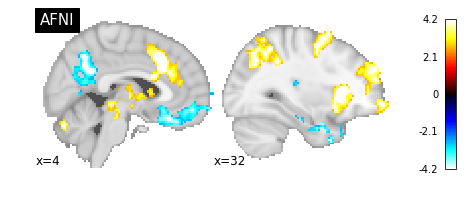

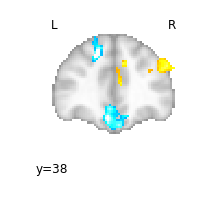

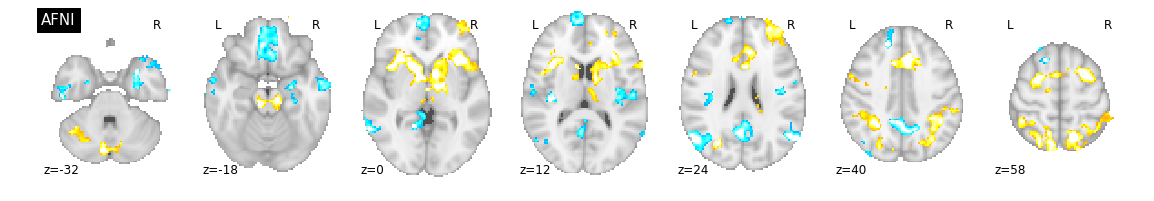

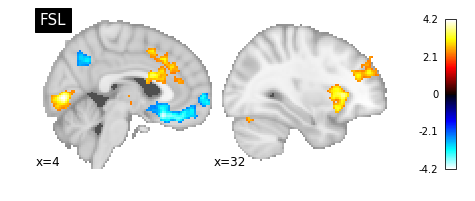

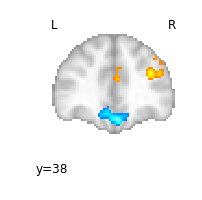

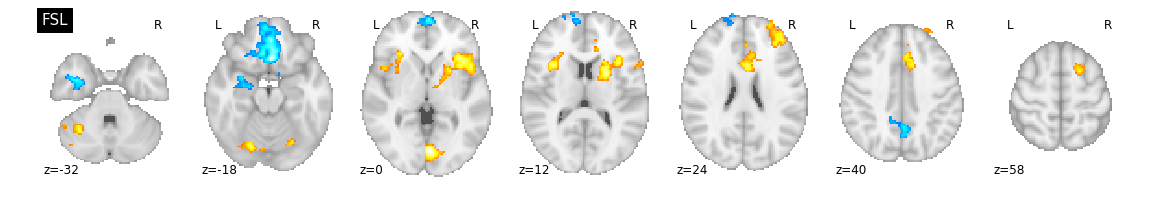

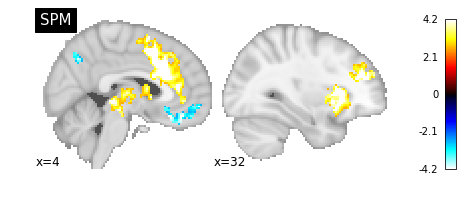

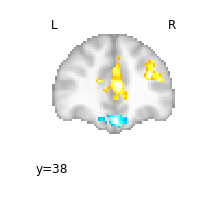

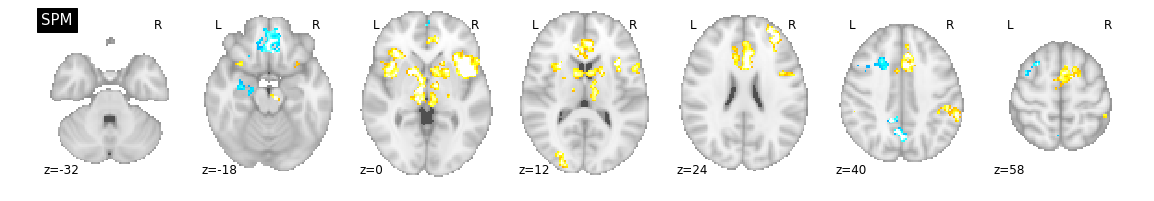

In [5]:
from lib import plot_excursion_sets
# Determine the scale of the activation colorbar
max_activation=4.2
# Determine the coordinates of the x, y, and z axial slices to be displayed
x_coords=[4, 32]
y_coords=[38]
z_coords=[-32, -18, 0, 12, 24, 40, 58]

reload(plot_excursion_sets)
plot_excursion_sets.plot_excursion_sets(exc_sets, max_activation, x_coords, y_coords, z_coords)

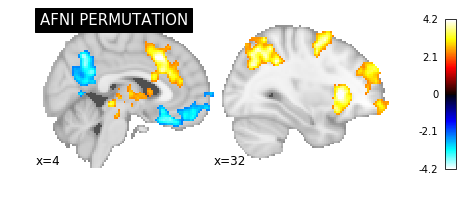

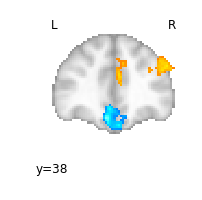

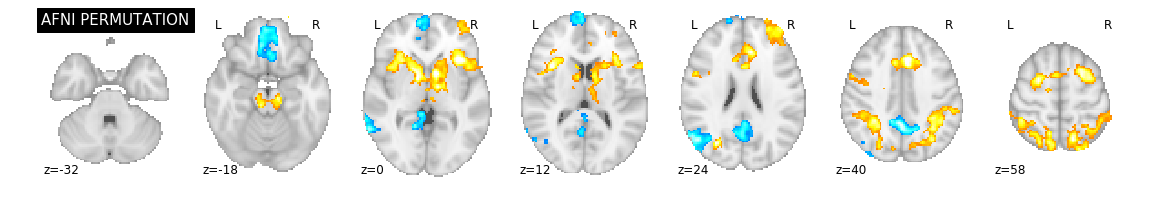

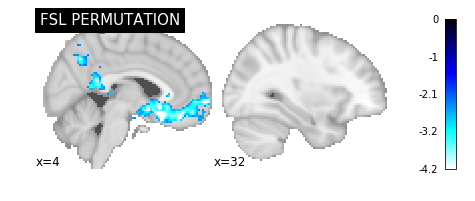

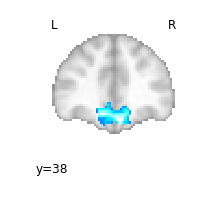

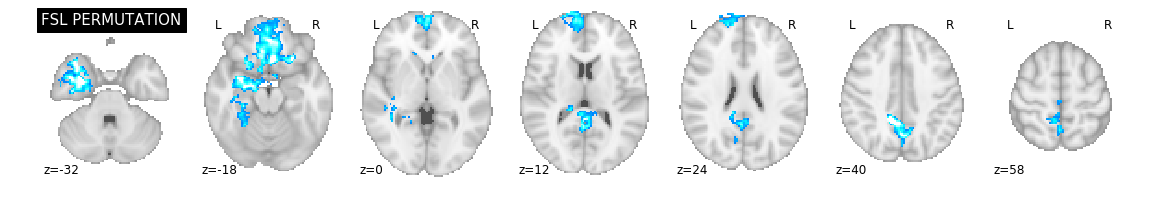

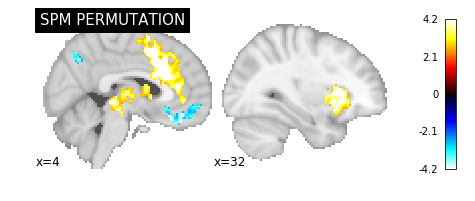

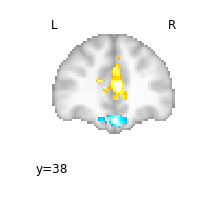

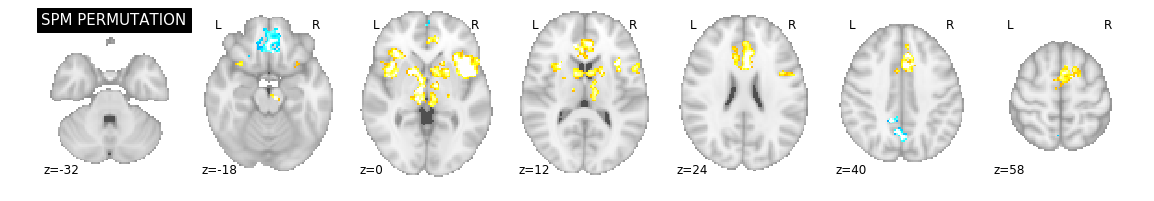

In [6]:
# Plot t-statistic images for permutation test inference results in each software
reload(plot_excursion_sets)
plot_excursion_sets.plot_excursion_sets(perm_exc_sets, max_activation, x_coords, y_coords, z_coords)

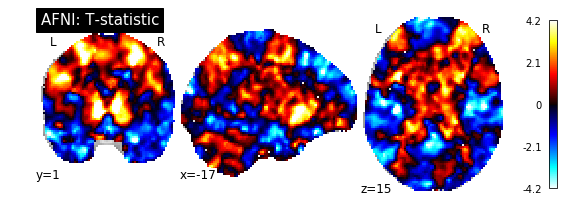

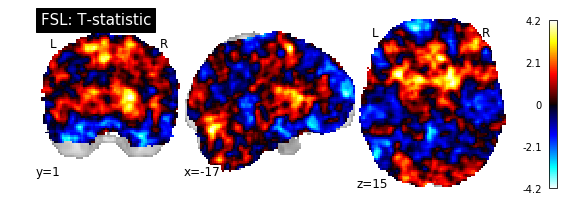

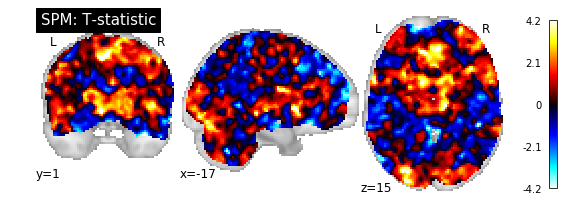

In [7]:
from lib import plot_stat_images
reload(plot_stat_images)
plot_stat_images.plot_stat_images(afni_stat_file, spm_stat_file, max_activation, [-17, 1, 15], 'T-statistic', fsl_stat_file)

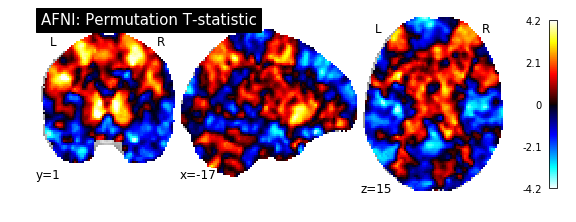

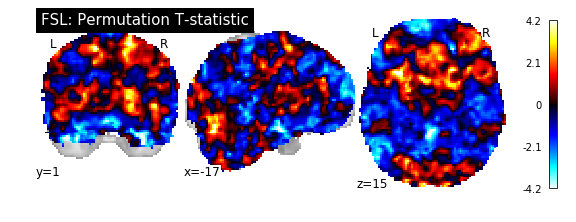

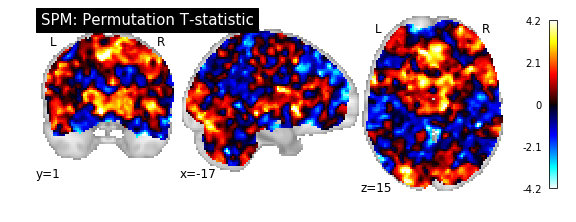

In [8]:
reload(plot_stat_images)
plot_stat_images.plot_stat_images(afni_perm, spm_perm, max_activation, [-17, 1, 15], 'Permutation T-statistic', fsl_perm)

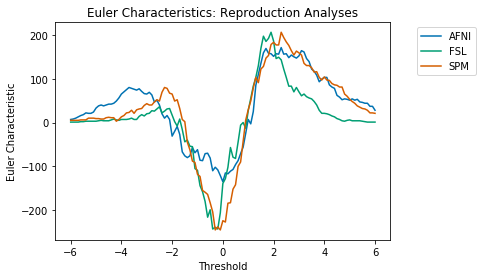

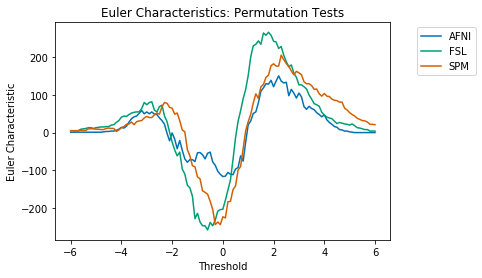

In [9]:
from lib import euler_characteristics
reload(euler_characteristics)
euler_characteristics.euler_characteristics(euler_chars, 'Reproduction Analyses')
euler_characteristics.euler_characteristics(perm_euler_chars, 'Permutation Tests')

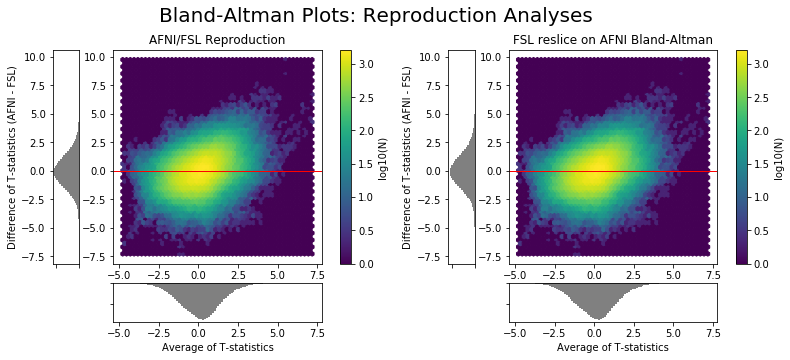

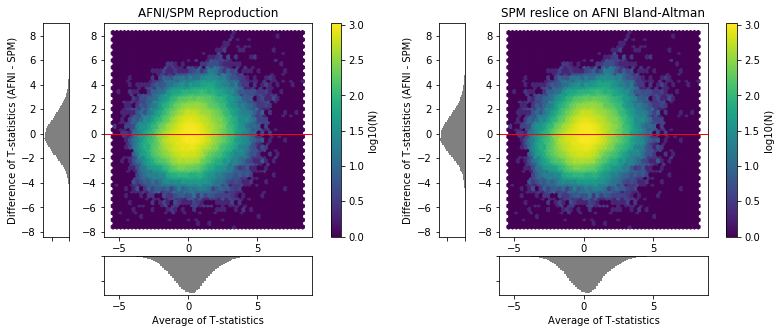

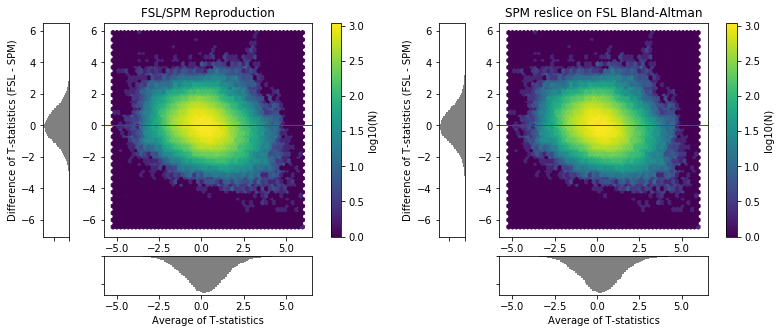

In [24]:
from lib import bland_altman
reload(bland_altman)
bland_altman.bland_altman('Bland-Altman Plots: Reproduction Analyses', afni_stat_file, spm_stat_file,
             afni_reslice_spm, afni_spm_reslice, 
            'AFNI/SPM Reproduction', 'AFNI/FSL Reproduction', 'FSL/SPM Reproduction',
             fsl_stat_file, fsl_reslice_spm,
             afni_fsl_reslice, afni_reslice_fsl, fsl_spm_reslice)

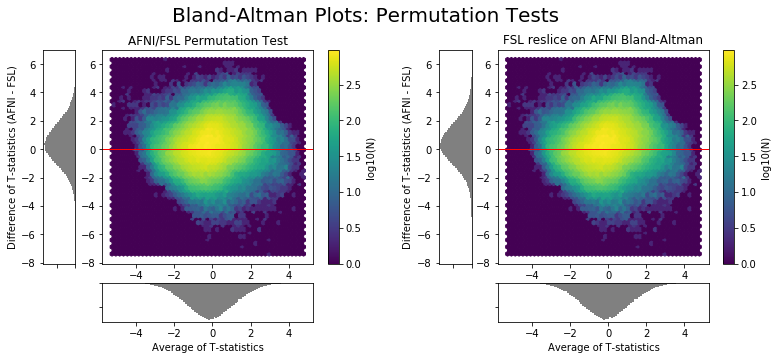

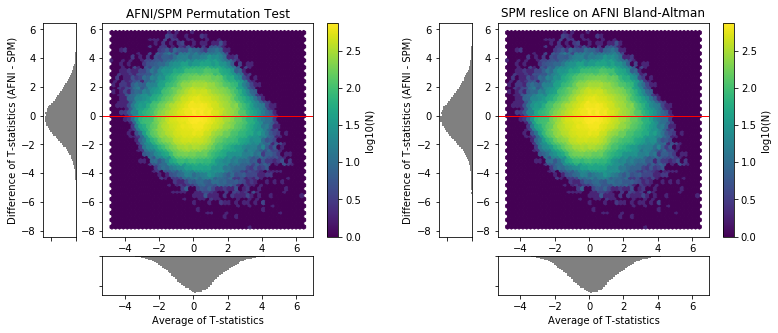

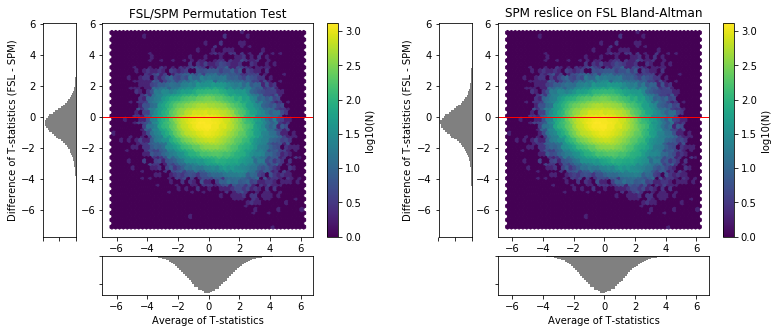

In [17]:
bland_altman.bland_altman('Bland-Altman Plots: Permutation Tests', afni_perm, spm_perm,
             afni_reslice_spm_perm, afni_spm_reslice_perm, 
            'AFNI/SPM Permutation Test', 'AFNI/FSL Permutation Test', 'FSL/SPM Permutation Test',
             fsl_perm, fsl_reslice_spm_perm,
             afni_fsl_reslice_perm, afni_reslice_fsl_perm, fsl_spm_reslice_perm)

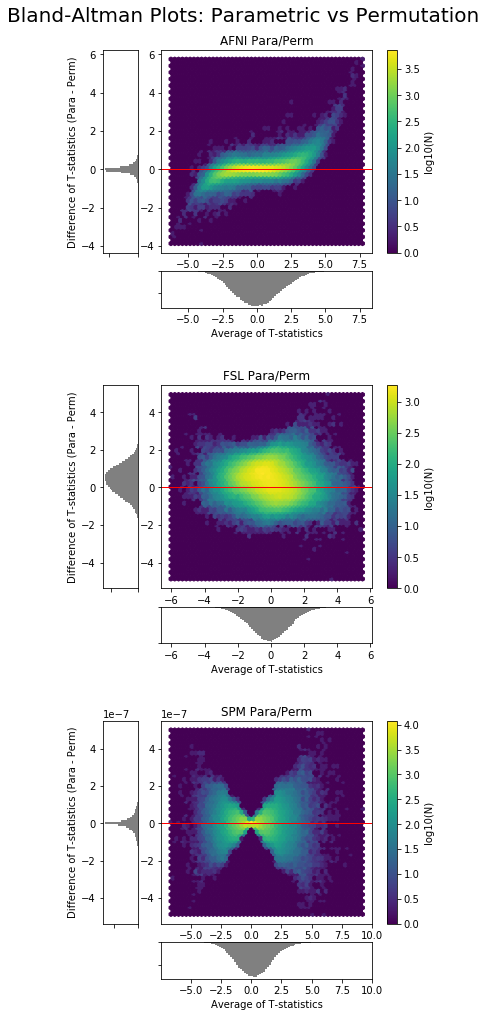

In [26]:
reload(bland_altman)
bland_altman.bland_altman_intra('Bland-Altman Plots: Parametric vs Permutation', afni_stat_file, afni_perm,
             fsl_stat_file, fsl_perm,
             spm_stat_file, spm_perm)

AFNI/FSL positive activation dice coefficient = 0.233421
FSL/AFNI positive activation dice coefficient = 0.233421
AFNI/SPM positive activation dice coefficient = 0.306612
SPM/AFNI positive activation dice coefficient = 0.306612
FSL/SPM positive activation dice coefficient = 0.365437
SPM/FSL positive activation dice coefficient = 0.365437
Permutation test AFNI/SPM positive activation dice coefficient = 0.294901
Permutation test SPM/AFNI positive activation dice coefficient = 0.294901
Permutation test AFNI/FSL positive activation dice coefficient = 0.000000
Permutation test FSL/AFNI positive activation dice coefficient = 0.000000
Permutation test FSL/SPM positive activation dice coefficient = 0.000000
Permutation test SPM/FSL positive activation dice coefficient = 0.000000
AFNI classical inference/permutation test positive activation dice coefficient = 0.869647
FSL classical inference/permutation test positive activation dice coefficient = 0.000000
SPM classical inference/permutation tes

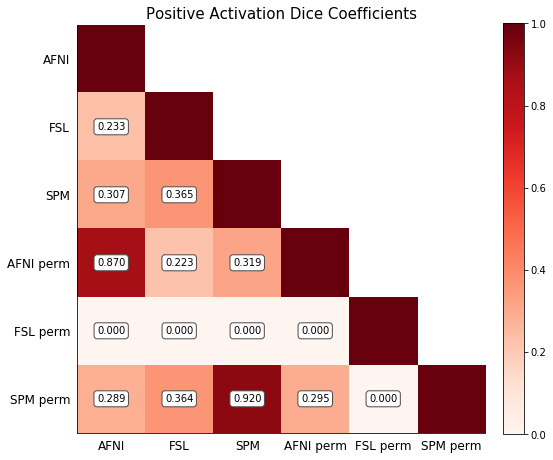

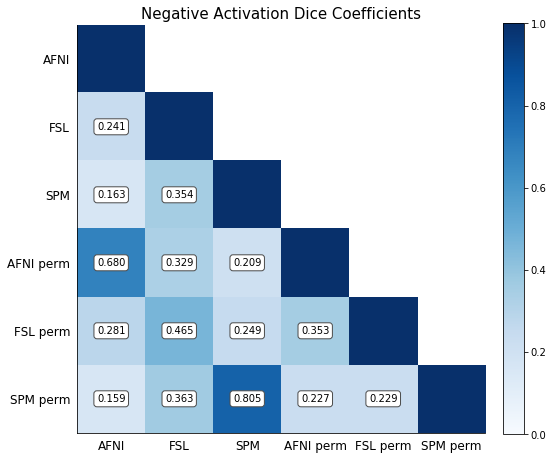

In [13]:
from lib import dice
reload(dice)
dice.dice(afni_exc_set_file, spm_exc_set_file, 
         afni_reslice_spm_pos_exc, afni_spm_reslice_pos_exc,
         afni_perm_pos_exc, spm_perm_pos_exc,
         afni_reslice_spm_pos_exc_perm, afni_spm_reslice_pos_exc_perm,
         afni_exc_set_file_neg, spm_exc_set_file_neg,
         afni_reslice_spm_neg_exc, afni_spm_reslice_neg_exc,
         afni_reslice_fsl_pos_exc, afni_reslice_fsl_neg_exc, 
         afni_fsl_reslice_pos_exc, afni_fsl_reslice_neg_exc,
         fsl_exc_set_file, fsl_exc_set_file_neg, 
         fsl_reslice_spm_pos_exc, fsl_reslice_spm_neg_exc,
         fsl_spm_reslice_pos_exc, fsl_spm_reslice_neg_exc,
         fsl_perm_pos_exc,
         afni_reslice_fsl_pos_exc_perm, afni_fsl_reslice_pos_exc_perm,
         fsl_reslice_spm_pos_exc_perm, fsl_spm_reslice_pos_exc_perm,
         afni_fsl_perm_reslice_pos_exc, afni_reslice_fsl_perm_pos_exc,
         afni_perm_reslice_fsl_pos_exc, afni_perm_fsl_reslice_pos_exc,
         afni_spm_perm_reslice_pos_exc, afni_reslice_spm_perm_pos_exc,
         afni_perm_reslice_spm_pos_exc, afni_perm_spm_reslice_pos_exc,
         fsl_spm_perm_reslice_pos_exc, fsl_reslice_spm_perm_pos_exc,
         fsl_perm_reslice_spm_pos_exc, fsl_perm_spm_reslice_pos_exc,
         afni_perm_neg_exc, fsl_perm_neg_exc, spm_perm_neg_exc,
         afni_reslice_fsl_neg_exc_perm, afni_fsl_reslice_neg_exc_perm,
         afni_reslice_spm_neg_exc_perm, afni_spm_reslice_neg_exc_perm,
         fsl_reslice_spm_neg_exc_perm, fsl_spm_reslice_neg_exc_perm,
         afni_fsl_perm_reslice_neg_exc, afni_reslice_fsl_perm_neg_exc,
         afni_perm_reslice_fsl_neg_exc, afni_perm_fsl_reslice_neg_exc,
         afni_spm_perm_reslice_neg_exc, afni_reslice_spm_perm_neg_exc,
         afni_perm_reslice_spm_neg_exc, afni_perm_spm_reslice_neg_exc,
         fsl_spm_perm_reslice_neg_exc, fsl_reslice_spm_perm_neg_exc,
         fsl_perm_reslice_spm_neg_exc, fsl_perm_spm_reslice_neg_exc)